### Momentum and Reversal Strategies as a simple to illustrate how a trading algorithm is designed


##### YiTao Hu

This Notebook illustrates in both concepts and Python code how a typical trading algorithm is designed. 

Warning: The methods in this notebook are only for illustrative and research purpose, NOT investment advice!!!

In [1]:
import alphien
universe= alphien.getTickersGlobalAllocationChallenge()
data = alphien.DataFeatures(tickers=universe.ticker.to_list(), fields = ["bb_live",'OHLCV'])
data.load(zoom='2002::2015')
prices = data.subset(tickers = universe[universe.field == 'bb live'].ticker.to_list(), fields = 'bb_live')
prices=prices.pxs
#compute returns
rtns=prices.pct_change().dropna()
OHLCV = data.subset(tickers = universe[universe.field == 'OHLCV'].ticker.to_list(), fields = 'OHLCV')
OHLCV =OHLCV.pxs

Hello Yitaohu, welcome to Alphien!

Importing your Alphien sub-packages into the alphien namespace...

from alphien.data import *
from alphien.portfolio import *
from alphien.tutorial import *

Importing your Qlib functions...                                   from team:
import alphien.getSampleCoefs                                      # yitaohu
import alphien.fitKDE                                              # yitaohu
import alphien.mpPDF                                               # yitaohu
import alphien.errPDFs                                             # yitaohu
import alphien.findMaxEval                                         # yitaohu
import alphien.CovtoCorr                                           # yitaohu
import alphien.Corr2Cov                                            # yitaohu
import alphien.Geteigns                                            # yitaohu
import alphien.deNoiseCov                                          # yitaohu
import alphien.EstdeNoisedCoeff    

First, we need to import the data from Alphien's API. For this trading competition called Global Allocation Challenge, I am asked to build a long-only and fully invested Portfolio with 19 (properly rolled) futures contracts covering all asset classes,weights for each asset less than 0.2. The investment universe are:

In [2]:
universe.loc[universe.field=='bb live',['ticker','description','currency','assetClass']]

,ticker,description,currency,assetClass
tablerownames,,,,
1,DM,Dow Jones Industrial,USD,Equity
2,SP,S&P 500,USD,Equity
3,NQ,NASDAQ 100,USD,Equity
4,VG,EuroStoxx 50,EUR,Equity
5,Z,FTSE 100,GBP,Equity
6,SMix,SMI Swiss Market Index,CHF,Equity
7,NX,CME Nikkei 225,JPY,Equity
8,HI,Hang Seng,HKD,Equity
9,KM,KOSPI 200,KRW,Equity


The data provided by the plantform is past trading data from 2003 to 2015, including daily close price of the 19 tickers listed, and Open Price, High Price, Low Price, Close Price and Volume of each first generic futures contract.
Here is a glimpse of the data.

In [3]:
prices.head()
#note bb_live is adjusted close price

,DM.bb_live,SP.bb_live,NQ.bb_live,VG.bb_live,Z .bb_live,SMix.bb_live,NX.bb_live,HI.bb_live,KM.bb_live,XP.bb_live,TU.bb_live,FV.bb_live,TY.bb_live,US.bb_live,RX.bb_live,G .bb_live,JB.bb_live,XM.bb_live,GC.bb_live
date,,,,,,,,,,,,,,,,,,,
2003-01-01,81.223671,164.304459,37.360985,66.049721,99.328468,68.610207,29.781334,162.013977,60.564194,90.142952,129.451157,151.460022,253.163086,186.593063,156.739685,148.479691,182.844604,113.051346,32.539436
2003-01-02,83.758553,169.632339,38.799400,69.634880,101.347290,68.610207,30.584820,162.851349,61.287918,90.802895,128.990585,149.997253,249.552856,182.401703,155.386826,147.542068,182.844604,113.069229,32.380932
2003-01-03,83.885300,170.099686,39.215782,69.276367,101.118744,72.587608,30.602285,167.160324,63.611450,91.972801,129.009384,149.997253,249.621643,182.608688,155.359207,147.282974,182.844604,112.789047,32.856438
2003-01-06,85.181992,173.202957,40.162113,70.820747,101.042564,72.483727,30.829357,168.521057,64.449448,92.362778,128.943588,149.704697,249.174667,182.194733,155.511047,147.332336,182.767380,112.795013,32.903057
2003-01-07,85.308731,172.698212,40.692055,69.800354,99.950623,71.919762,30.060806,169.061859,62.773457,92.632751,129.084595,150.039047,249.827942,182.712189,155.911392,147.455704,182.754501,112.896355,32.492817


In [4]:
OHLCV.head()

,DM1 Index.open_price,DM1 Index.high_price,DM1 Index.low_price,DM1 Index.close_price,DM1 Index.volume,SP1 Index.open_price,SP1 Index.high_price,SP1 Index.low_price,SP1 Index.close_price,SP1 Index.volume,...,XM1 Comdty.open_price,XM1 Comdty.high_price,XM1 Comdty.low_price,XM1 Comdty.close_price,XM1 Comdty.volume,GC1 Comdty.open_price,GC1 Comdty.high_price,GC1 Comdty.low_price,GC1 Comdty.close_price,GC1 Comdty.volume
date,,,,,,,,,,,,,,,,,,,,,
2003-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-02,8320.0,8610.0,8316.0,8591.0,22036.0,883.000000,910.000000,882.700012,907.400024,58332.0,...,94.830002,94.875000,94.830002,94.834999,3483.0,347.600006,348.200012,342.799988,346.500000,35814.0
2003-01-03,8586.0,8621.0,8535.0,8604.0,19570.0,907.500000,910.700012,901.700012,909.900024,46013.0,...,94.839996,94.845001,94.589996,94.599998,13156.0,346.000000,353.500000,343.600006,351.600006,42524.0
2003-01-06,8630.0,8787.0,8561.0,8737.0,18817.0,911.000000,931.500000,903.799988,926.500000,63551.0,...,94.599998,94.650002,94.504997,94.605003,21227.0,351.399994,357.000000,350.500000,352.100006,39551.0
2003-01-07,8727.0,8788.0,8691.0,8750.0,23716.0,926.200012,930.500000,918.799988,923.799988,79159.0,...,94.595001,94.714996,94.580002,94.690002,13672.0,351.899994,352.000000,345.000000,347.700012,41401.0


### Overall structure of a trading algorithm

<img src="OverallStructureOfTradingAlgo.png">

To be more specific, we need a method to estimate future expected returns (Alphas) of all assets, a method to estimate covariance matrix of all assets, and a method to estimate our costs to trade all assets(commission and adverse price impact). To be more clear, alphas will be a n $\times$ 1 vector, with each element as your estimated expected return for each asset. Trading costs will be a n $\times$ 1 vector, with each element as your estimated percentage cost to trade each asset. Risk Model or Covariance matrix is a n $\times$ n matrix, with each element as the covariance between two assets. Once we have these three estimates, we will use these three estimates as input for Optimizer, which will return the portfolio weights for each asset for the next holding period (next day, month, or year) in accordance with your goal and constraints.

I did not build a trading cost model or estimation method here because the trading cost is ignorable if you trade unfrequently and has limited amount of money in your portfolio. 

Here is a glimpse of the structure of alphas and Covariance matrix using simple sample mean and sample covariance matrix as our estimates.

In [28]:
rtns.iloc[:252].mean(axis=0)

DM.bb_live      0.000918
SP.bb_live      0.000911
NQ.bb_live      0.001550
VG.bb_live      0.000730
Z .bb_live      0.000556
SMix.bb_live    0.000794
NX.bb_live      0.000841
HI.bb_live      0.001360
KM.bb_live      0.001252
XP.bb_live      0.000297
TU.bb_live      0.000059
FV.bb_live      0.000101
TY.bb_live      0.000119
US.bb_live      0.000152
RX.bb_live      0.000091
G .bb_live     -0.000057
JB.bb_live     -0.000031
XM.bb_live     -0.000016
GC.bb_live      0.000649
dtype: float32

This output means we think DM is going to have a 0.09% return next day and so on. But this estimate is very very inaccurate becasue of sampling errors.

In [30]:
#for the sample covariance matrix 
rtns.iloc[:252].cov().head()

,DM.bb_live,SP.bb_live,NQ.bb_live,VG.bb_live,Z .bb_live,SMix.bb_live,NX.bb_live,HI.bb_live,KM.bb_live,XP.bb_live,TU.bb_live,FV.bb_live,TY.bb_live,US.bb_live,RX.bb_live,G .bb_live,JB.bb_live,XM.bb_live,GC.bb_live
DM.bb_live,0.000102,0.000102,0.000133,0.000134,0.000057,0.000065,0.000083,0.000016,0.000018,1.299439e-06,-0.000004,-0.000010,-0.000015,-0.000023,-0.000015,-0.000011,-3.178504e-07,-6.196414e-07,-0.000036
SP.bb_live,0.000102,0.000106,0.000142,0.000136,0.000056,0.000063,0.000087,0.000014,0.000015,-1.503949e-06,-0.000004,-0.000010,-0.000015,-0.000022,-0.000015,-0.000011,-6.163451e-07,-6.108772e-07,-0.000035
NQ.bb_live,0.000133,0.000142,0.000243,0.000182,0.000074,0.000079,0.000137,0.000031,0.000034,-9.171179e-07,-0.000006,-0.000016,-0.000023,-0.000035,-0.000023,-0.000016,-2.019995e-06,-1.622612e-06,-0.000054
VG.bb_live,0.000134,0.000136,0.000182,0.000359,0.000181,0.000200,0.000136,0.000046,0.000075,1.214931e-05,-0.000009,-0.000024,-0.000036,-0.000055,-0.000040,-0.000031,-2.663160e-06,-1.905722e-06,-0.000072
Z .bb_live,0.000057,0.000056,0.000074,0.000181,0.000151,0.000140,0.000067,0.000042,0.000066,1.916452e-05,-0.000004,-0.000011,-0.000016,-0.000026,-0.000019,-0.000018,-7.991270e-07,-2.017479e-06,-0.000022


This output means we think DM and SP returns in the next day has a 0.000102 covariance and so on. But again, this estimate is very very inaccurate becasue of sampling errors. From here, we can see most of the work in building trading algorithm is actually building robust estimation methods for alphas and Covariance Matrix. And a lot of Machine Learning methods can help asset managers to estimate these two parameters.

### How we get Estimate of Alphas

#### Signals

Typically, we think there are some signals that are positively or negatively correlated with an asset's future expected returns, like past 12 months return, book-to-market ratio, and cap size. And we typically will use these signals to estimate each stock's expected returns for the next period.

For example, I used straight momentum and short-term reversal signals here for illustrative purpose. 

But signals can be anything that is related with an asset's future expected return, i.e. a numeric number got from processing textual data on a news about Tesla, or a numeric number got from processing the picture from the C.E.O.

Straight momentum signal is defined as the asset's last year's cumulative return excluding the most recent month. Studies have proven that past year's winner assets are more likely to be future winner assets.

Short-term Reversal signal is defined as the asset's last 20 trading days return. Studies have proven that past month's loser assets are more likely to be future winner assets.

Mathematically:
$$signal_{Mom_i}=\frac{1}{252-20} \sum_{t=1}^{232}R_{i,t}$$

$$signal_{STR_i}=-\frac{1}{20} \sum_{t=1}^{20}R_{i,t}$$

Note there is a negative sign because past month's return is negatively correlated with future returns. But keep in mind, each stock has its own signals at each rebalance time (each day, month,year).

#### Proceed Signals to Alphas

After we compute or get stock-timestep level signals, we will standardize the signals, which is cross-sectionally demean and divide by standard deviation. This is to make all signals unitless, because raw MOM signals are in %, while Book-to-Market ratio is between 0 and 1.

Mathematically，
$$alpha_{i,t}=\frac{signal_{i,t}-\frac{1}{n}\sum_{i}^{n}signal_{i,t}}{std(signal_{i,t})}$$

#### Aggregate Alphas

The last step is to aggregate alphas with some modulators. Modulators are defined as a third varable which has an effect on the effectiveness of alphas.

For example, studies shown that short-term-reversal effects are more significant when trading volume is high, and so trading volume would be a good modulator for short-term-reversal alpha. 

Mathematically, only for this simple trading algorithm:

$$alphablend{i,t}=alphaMom_{i,t}+alphaSTR_{i,t} \times norm.cdf(StandardizedVolume_{i,t})$$

We use norm.cdf or cumulative probability function of standard normal variable on Standardized trading Volume to generate a weight b/w 0 and 1 to decide how much we trust short-term-reversal alpha.

The following codes are writted to perform the process described above.

In [39]:
#import libs
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf
from scipy.optimize import minimize
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples 
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from sklearn import decomposition

def AlphaDecay(signal,decay_weights):
    alpha=(signal*decay_weights).sum()
    return alpha
def signal_standardize(alpha,Winsorize=True):
    alpha=(alpha-alpha.mean())/alpha.std()
    if Winsorize:
        alpha[alpha<-3]=-3
        alpha[alpha>3]=3
    return alpha
def CptReversalAlpha(ret_act):
    #compute signal of reversal
    #set Triangular weights
    Tri_weights=np.array([1/11-1/231*j for j in range(21)])[::-1]
    Tri_weights=np.repeat(Tri_weights,ret_act.shape[1]).reshape(21,ret_act.shape[1])
    #compute weighted revsersal signal
    alpharev=-AlphaDecay(ret_act,decay_weights=Tri_weights)
    #standardize and winsorize the signal
    alpharev=signal_standardize(alpharev)
    return alpharev
def CptMomAlpha(ret_act):
    ##setting decay weights: the most recent month would be zero,equal weights other 11 months
    Decay_weights=np.ones(252)/(252-21)
    Decay_weights[252-21:]=0
    Decay_weights=np.repeat(Decay_weights,ret_act.shape[1]).reshape(252,ret_act.shape[1])
    alphamom=AlphaDecay(ret_act,decay_weights=Decay_weights)
    #standardize and winsorize the signal
    alphamom=signal_standardize(alpharev)
    return alphamom

def CptStatsAlpha(ret_act):
    ##setting decay weights: the most recent month would be zero,equal weights other 11 months
    Decay_weights=np.ones(252)/252
    #try some stats factor
    PCA_model=decomposition.PCA(n_components=5)
    PCA_model.fit(ret_act)
    loadings=PCA_model.components_
    factors=PCA_model.transform(ret_act)
    Stats_er=(factors@loadings).mean(axis=0)
    #stantadrize stats factors
    alphastats=signal_standardize(Stats_er)
    return alphastats

def CptVolumeAlpha(volume):
    Longvolume=volume.mean(axis=0)
    Shortvolume=volume.iloc[-21:].mean(axis=0)
    alphaVolume=Shortvolume-Longvolume
    alphaVolume=signal_standardize(alphaVolume)
    return alphaVolume

Here is our mom and reversal alpha, computed for the first year.

In [35]:
CptMomAlpha(rtns.iloc[:252])

DM.bb_live      1.306948
SP.bb_live      1.147388
NQ.bb_live      0.622045
VG.bb_live      1.402309
Z .bb_live      1.028866
SMix.bb_live    1.002109
NX.bb_live      0.407126
HI.bb_live      0.211241
KM.bb_live      1.265597
XP.bb_live      0.137908
TU.bb_live     -0.766001
FV.bb_live     -0.790946
TY.bb_live     -0.819547
US.bb_live     -0.973415
RX.bb_live     -0.949777
G .bb_live     -0.935447
JB.bb_live     -0.894987
XM.bb_live     -0.734350
GC.bb_live     -1.667065
dtype: float64

In [38]:
CptReversalAlpha(rtns.iloc[:21])

DM.bb_live      1.306948
SP.bb_live      1.147388
NQ.bb_live      0.622045
VG.bb_live      1.402309
Z .bb_live      1.028866
SMix.bb_live    1.002109
NX.bb_live      0.407126
HI.bb_live      0.211241
KM.bb_live      1.265597
XP.bb_live      0.137908
TU.bb_live     -0.766001
FV.bb_live     -0.790946
TY.bb_live     -0.819547
US.bb_live     -0.973415
RX.bb_live     -0.949777
G .bb_live     -0.935447
JB.bb_live     -0.894987
XM.bb_live     -0.734350
GC.bb_live     -1.667065
dtype: float64

#### Estimate Cov Matrix

Advanced methods to estimate Cov matrix are much more complex. If interetsed, plz go to the Appendix section of the file 'QAMFinal_Project_Report'.

The following codes are writted to perform methods described in the report.

In [41]:
#functions to return mean vector and cov mat optional to perform Ledoit-Wolf shrinkage 
def getSampleCoefs(Obs,shrink=False):
    mu_vec=Obs.mean(axis=0)
    if shrink:
        Covmat=LedoitWolf().fit(Obs).covariance_
    else: Covmat=np.cov(Obs,rowvar=False)
    return np.array(mu_vec),Covmat
def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
# Fit kernel to a series of obs, and derive the prob of obs
# x is the array of values on which the fit KDE will be evaluated 
    if len(obs.shape)==1:obs=obs.reshape(-1,1) 
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs) 
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1) 
    logProb=kde.score_samples(x) # log(density) 
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2 
    eVal=np.linspace(eMin,eMax,pts)
    eVal=eVal.reshape(1000)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 
    pdf=pd.Series(pdf,index=eVal)
    return pdf
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf 
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf 
    sse=np.sum((pdf1-pdf0)**2)
    return sse
def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko's dist to the empirical one
    out=minimize(lambda *x:errPDFs(*x),.5,args=(eVal,q,bWidth), bounds=((1E-5,1-1E-5),))
    if out['success']:var=out['x'][0] 
    else:var=1 
    eMax=var*(1+(1./q)**.5)**2 
    return eMax,var
#function to transform from cov mat to corr mat and vice versa
def CovtoCorr(cov):
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std) 
    corr[corr<-1],corr[corr>1]=-1,1 
    return corr
def Corr2Cov(corr,std):
    cov=corr*np.outer(std,std)
    return cov
#function to do diagnization 
def Geteigns(Xmat):
    # Get eVal,eVecs
    eVals,eVecs=np.linalg.eigh(Xmat)
    indices=eVals.argsort()[::-1] # index for sorting eVal desc 
    eVals,eVecs=eVals[indices],eVecs[:,indices] 
    #make the eigenvalues a diagnal mat
    eVals=np.diagflat(eVals)
    return eVals,eVecs
#function to shrink the Corr mat further by avgering small eignvalues
def deNoiseCov(cov0,n_pcs=None,q=None,bWidth=None):
    #get eigenvals,eigenvectors of corr
    corr0=CovtoCorr(cov0)
    eVal0,eVec0=Geteigns(corr0) 
    eVal1=eVal0.diagonal().copy()
    if n_pcs==None:
        #find eMax0
        eMax0,var0=findMaxEval(eVal=eVal1,q=q,bWidth=bWidth)
        #find n_pcs
        n_pcs=len(eVal1)-eVal1[::-1].searchsorted(eMax0)
    #average all the small eigenvalues
    eVal1[n_pcs:]=np.mean(eVal1[n_pcs:])
    eVal1=np.diag(eVal1)
    #compute shrinked corr mat
    corr1=np.dot(eVec0,eVal1).dot(eVec0.T)
    #get back to cov mat
    cov1=Corr2Cov(corr1,np.diag(cov0)**.5)
    return cov1
#function to estimate grand shrinked cov mat
def EstdeNoisedCoeff(Obs,n_pcs=None,q=None,bWidth=None,shrink=False):
    mu0,Cov0=getSampleCoefs(Obs=Obs,shrink=shrink)
    #regularize Cov mat
    Cov1=deNoiseCov(cov0=Cov0,n_pcs=n_pcs,q=q,bWidth=bWidth)
    return mu0,Cov1

Here is a glimpse of our estimate using the first year's data.

In [49]:
mu,Cov=EstdeNoisedCoeff(rtns.iloc[:252],n_pcs=None,q=252/19,bWidth=0.25,shrink=True)
pd.DataFrame(Cov,index=rtns.columns,columns=rtns.columns).head()

,DM.bb_live,SP.bb_live,NQ.bb_live,VG.bb_live,Z .bb_live,SMix.bb_live,NX.bb_live,HI.bb_live,KM.bb_live,XP.bb_live,TU.bb_live,FV.bb_live,TY.bb_live,US.bb_live,RX.bb_live,G .bb_live,JB.bb_live,XM.bb_live,GC.bb_live
DM.bb_live,0.000127,0.000077,0.000109,0.000128,0.000062,0.000069,0.000074,0.000015,0.000017,-0.000003,-0.000003,-0.000009,-0.000014,-0.000021,-0.000016,-0.000012,-2.437014e-07,-5.208799e-07,-0.000038
SP.bb_live,0.000077,0.000134,0.000112,0.000130,0.000062,0.000069,0.000076,0.000013,0.000014,-0.000004,-0.000003,-0.000009,-0.000014,-0.000021,-0.000016,-0.000012,-1.626203e-08,-4.157651e-07,-0.000040
NQ.bb_live,0.000109,0.000112,0.000280,0.000186,0.000090,0.000100,0.000108,0.000022,0.000025,-0.000004,-0.000005,-0.000014,-0.000021,-0.000032,-0.000024,-0.000018,-3.741658e-07,-7.902741e-07,-0.000056
VG.bb_live,0.000128,0.000130,0.000186,0.000422,0.000128,0.000148,0.000146,0.000058,0.000085,0.000016,-0.000009,-0.000024,-0.000036,-0.000053,-0.000036,-0.000029,-4.250620e-06,-2.952311e-06,-0.000064
Z .bb_live,0.000062,0.000062,0.000090,0.000128,0.000152,0.000091,0.000082,0.000051,0.000078,0.000020,-0.000004,-0.000011,-0.000017,-0.000025,-0.000018,-0.000016,-4.630271e-06,-2.501769e-06,-0.000028


### Optimizer

Once we have alpha and Cov matrix estimator, we are ready to use optimizer. In this case, our goal is to maximize Sharpe Ratio, ans so we will set Sharpe Ratio as our optimization target. We also adds the constraints: 

weights have to sum up to 1, 

max weight for one asset cannot be more than 0.2, 

and No short position.

In [8]:
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 0.2),) * n # set the position bds
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = weights.T @ er
        vol = (weights.T @ cov @ er)**0.5
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

Lastly, we will assemble everything together into a function, which generate weights when we put last year's price and volume information as inputs. One Step Weight does this.

In [51]:
def oneStepWeighting(Obs,volume):
    mu,Cov=EstdeNoisedCoeff(Obs,n_pcs=None,q=252/19,bWidth=0.25,shrink=True)
    alphamom=CptMomAlpha(Obs)
    alpharev=CptReversalAlpha(Obs.iloc[-21:])
    alphavolume=CptVolumeAlpha(volume)
    alphastats=CptStatsAlpha(Obs)
    er=0.5*(alpharev.values*norm.cdf(alphavolume.values)+alphamom.values+alphavolume.values)+0.5*alphastats
    weights=msr(0,er,Cov)
    #make sure weights always sum to 1
    weights=weights/weights.sum()
    return weights

Here is a glimpse of the weights generated at the beginning of 2004, if we use 2003's price and volume data to estimate alphas and Cov Matrix.

In [54]:
pd.DataFrame(oneStepWeighting(rtns.iloc[:252],volume.iloc[:252]),index=rtns.columns)

,0
DM.bb_live,0.000037
SP.bb_live,0.000039
NQ.bb_live,0.000084
VG.bb_live,0.000050
Z .bb_live,0.109874
SMix.bb_live,0.000046
NX.bb_live,0.000039
HI.bb_live,0.002373
KM.bb_live,0.003088
XP.bb_live,0.148950


### Trading rules and Backtest

The final step is to set trading rules and perform backtest.

Here we set our estimation_window as 252 trading days, and so we will using a rolling window of 252 trading days' information to estimate alphas and Covariance Matrix.

Also, we set our rebalance interval as 21 trading days, and so we will adjust our portfolio weights monthly.

In [50]:
from alphien import getTickersGlobalAllocationChallenge

In [21]:
def MomReversalGlobalAllocationChallenge(features, estimation_window=252,rebalance_interval=21):
    
    # Get ticker function for all information related to the ticker
    df = getTickersGlobalAllocationChallenge()
    
    # Getting BB data from features
    bbLive = features.subset(tickers=df[df.field == 'bb live'].ticker.to_list(), fields="bb_live")
    bbLive = bbLive.pxs
    #fill all na in returns as 0
    rtns=bbLive.pct_change().iloc[1:].fillna(0)
    
    # Getting volume from features
    volume = features.subset(tickers=df[df.field == 'OHLCV'].ticker.to_list(), fields="volume")
    volume = volume.pxs
    volume = volume.fillna(0)
    #use trading volume as modulator 
    volume = signal_standardize(volume,Winsorize=False)

    #propulate the weighting scheme to a time series
    n_periods = rtns.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in np.arange(0,n_periods-estimation_window,rebalance_interval)]
    weights = [oneStepWeighting(rtns.iloc[win[0]:win[1]],volume.iloc[win[0]:win[1]]) for win in windows]
    # convert List of weights to DataFrame
    weights = pd.DataFrame(weights, index=rtns.iloc[np.arange(estimation_window,rtns.shape[0],rebalance_interval)].index, columns=rtns.columns)
    
    return(weights)

In [22]:
portAllocation = alphien.Portfolio(universe[universe.field=="bb live"].ticker.to_list())
portAllocation.addFeatures(tickers=universe.ticker.to_list(), fields = ["bb live","volume"])



Dropping duplicated ticker(s): DM, SP, NQ, VG, Z , SMix, NX, HI, KM, XP, TU, FV, TY, US, RX, G , JB, XM, GC
Dropping duplicated field(s): bb_live


In [24]:
portAllocation.payout(MomReversalGlobalAllocationChallenge, estimation_window=252)

In [25]:
portAllocation.evaluate(zoom="2003::2015")

Generating portfolio weights using MomReversalGlobalAllocationChallenge payout..
Generating portfolio daily returns..


### BackTest

Here we impose a trading cost of 1 bp for our backtest to be more realistic, and see how our stratgey performs during the period from 2004 to 2015.


        Strategy Summary:
        Annualised Return:       6.88%
        Total Return:          122.41%
        Annualised Volatility:  13.21%
        Maximum Drawdown:      -48.02%   
        Sharpe Ratio:            0.52
        Calmar Ratio:            0.14
        

Output is limited to top and bottom 5 assets by Sharpe Ratio.


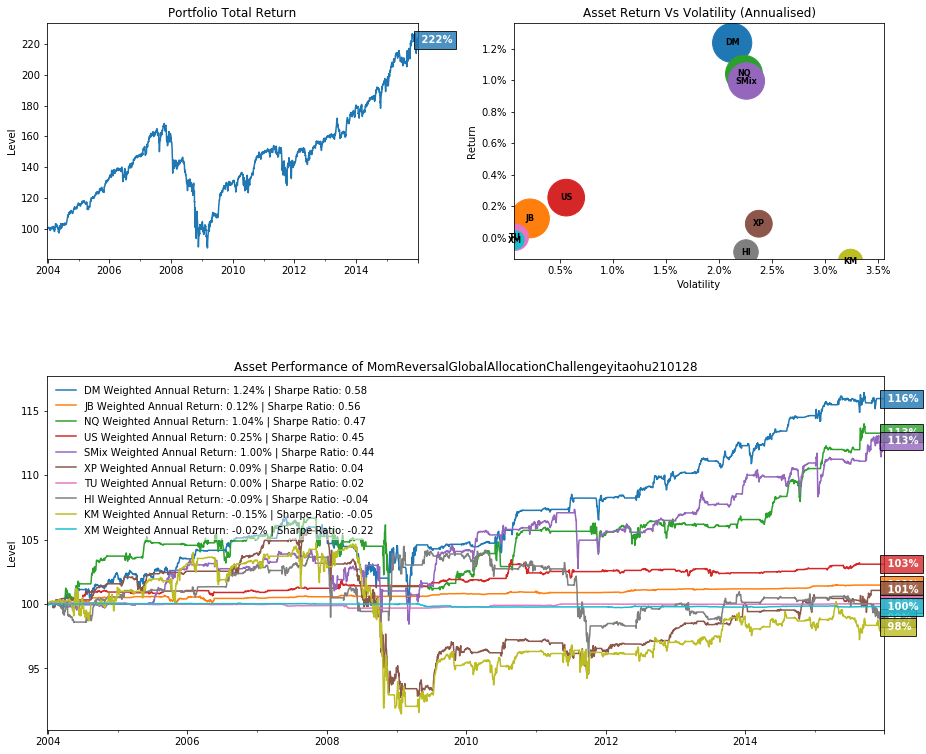

In [26]:
portAllocation.backtest(tc=0.01, rebalancePenalty=0.02, rebalancePenaltyPerAsset=False)

From the description above, you can see that building trading algorithms are NOT fundamentally different from mannual analysis performed in spreadsheet. Both analysis needs new ideas (sources of alphas) and diversification ideas (methods to estimate Cov Matrix) to outperform the benchmark (typically SP500). The only difference is that trading algorithms augment all these ideas in a systematic and quantitative way so that we are much easier to test and evaluate our startegy. 